# Juice Examples
This notebook includes:
- Logic Circuits
    - Construct a circuit
    - Structure Properties
    - Transformations
    - Queries
- Probabilistic Circuits
## Logic Circuits

In [66]:
using Revise # TODO remove 

In [2]:
using LogicCircuits

### Construct/ Load/ Compile a logic circuit
1. Handcradft a logic circuit

In [3]:
lit1, litn1 = compile(PlainLogicCircuit, Lit(1)), compile(PlainLogicCircuit, Lit(- 1))
lit2, litn2 = compile(PlainLogicCircuit, Lit(2)), compile(PlainLogicCircuit, Lit(- 2))
and1 = lit1 & lit2
true_node = compile(PlainLogicCircuit, true)
and2 = conjoin([litn1, litn2, true_node])
c1 = and1 | and2
println(tree_formula_string(c1))

((1 ⋀ 2) ⋁ (-1 ⋀ -2 ⋀ true))


In [4]:
# structured-decomposble circuit and its vtree
v1, v2 = Vtree(Var(1)), Vtree(Var(2))
v_and = Vtree(v1, v2)
sl1, sln1 = compile(StructLogicCircuit, v1, Lit(1)), compile(StructLogicCircuit, v1, Lit(- 1))
sl2, sln2 = compile(StructLogicCircuit, v2, Lit(2)), compile(StructLogicCircuit, v2, Lit(- 2))
c2 = v_and(v_and(sl1 & sl2) | v_and(sln1 & sln2))
println(tree_formula_string(c2))

((1 ⋀ 2) ⋁ (-1 ⋀ -2))


2. Load from file/module zoo

In [5]:
lc = load_logic_circuit(zoo_sdd_file("random.sdd"))
lc2 = load_smooth_logic_circuit(zoo_psdd_file("nltcs.psdd"))
lc, v = load_struct_smooth_logic_circuit(zoo_psdd_file("nltcs.psdd"), zoo_vtree_file("nltcs.vtree"))

(PlainStruct⋁Node(17071440171319300258), PlainVtreeInnerNode(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16))

3. fully factorized circuit

In [6]:
c3 = fully_factorized_circuit(PlainLogicCircuit, 3)
c4 = fully_factorized_circuit(PlainStructLogicCircuit, v_and)
println(tree_formula_string(c3))
println(tree_formula_string(c4))

(((1 ⋁ -1) ⋀ (2 ⋁ -2) ⋀ (3 ⋁ -3)))
((((1 ⋁ -1) ⋀ (2 ⋁ -2))))


4. SDD compilation 

In [7]:
mgr1 = SddMgr(3, :balanced)

cnf1 = zoo_cnf("easy/C17_mince.cnf")
vtree1 = zoo_vtree("easy/C17_mince.min.vtree");

mgr2 = SddMgr(vtree1)
cnfΔ = compile(mgr2, cnf1)
println(tree_formula_string(cnfΔ))

((-3 ⋀ ((((2 ⋀ true) ⋁ (-2 ⋀ -4)) ⋀ false) ⋁ (((2 ⋀ false) ⋁ (-2 ⋀ 4)) ⋀ ((((7 ⋀ 8) ⋁ (-7 ⋀ -8)) ⋀ false) ⋁ (((-7 ⋀ 8) ⋁ (7 ⋀ false)) ⋀ ((-6 ⋀ ((-9 ⋀ ((10 ⋀ ((11 ⋀ ((12 ⋀ ((13 ⋀ ((14 ⋀ ((-15 ⋀ ((-16 ⋀ 17) ⋁ (16 ⋀ false))) ⋁ (15 ⋀ false))) ⋁ (-14 ⋀ false))) ⋁ (-13 ⋀ ((-14 ⋀ ((15 ⋀ ((-16 ⋀ 17) ⋁ (16 ⋀ false))) ⋁ (-15 ⋀ false))) ⋁ (14 ⋀ false))))) ⋁ (-12 ⋀ false))) ⋁ (-11 ⋀ false))) ⋁ (-10 ⋀ false))) ⋁ (9 ⋀ false))) ⋁ (6 ⋀ false))) ⋁ (((7 ⋀ -8) ⋁ (-7 ⋀ false)) ⋀ ((-6 ⋀ ((9 ⋀ ((-10 ⋀ ((11 ⋀ ((-12 ⋀ ((13 ⋀ ((14 ⋀ ((-15 ⋀ ((-16 ⋀ 17) ⋁ (16 ⋀ false))) ⋁ (15 ⋀ false))) ⋁ (-14 ⋀ false))) ⋁ (-13 ⋀ ((-14 ⋀ ((15 ⋀ ((16 ⋀ -17) ⋁ (-16 ⋀ false))) ⋁ (-15 ⋀ false))) ⋁ (14 ⋀ false))))) ⋁ (12 ⋀ false))) ⋁ (-11 ⋀ false))) ⋁ (10 ⋀ false))) ⋁ (-9 ⋀ false))) ⋁ (6 ⋀ false))))))) ⋁ (3 ⋀ ((1 ⋀ ((((2 ⋀ 4) ⋁ (-2 ⋀ true)) ⋀ false) ⋁ (((2 ⋀ -4) ⋁ (-2 ⋀ false)) ⋀ ((((-7 ⋀ -8) ⋁ (7 ⋀ true)) ⋀ false) ⋁ (((-7 ⋀ 8) ⋁ (7 ⋀ false)) ⋀ ((-5 ⋀ ((-6 ⋀ ((9 ⋀ ((-10 ⋀ ((11 ⋀ ((-12 ⋀ ((13 ⋀ ((14 ⋀ ((-15 ⋀ ((-16 ⋀ 17) ⋁ (16 ⋀ fals

2. Circuit Statistics

In [8]:
println(tree_formula_string(c1))
println("Number of variables : ", num_variables(c1))
println("Number of nodes : ", num_nodes(c1))
println("Number of edges : ", num_edges(c1))

((1 ⋀ 2) ⋁ (-1 ⋀ -2 ⋀ true))
Number of variables : 2
Number of nodes : 8
Number of edges : 7


In [9]:
println("Number of children of root node : ", num_children(c1))
println("Inner nodes : ", innernodes(c1), "\n")
println("Leaf nodes : ", leafnodes(c1), "\n")
println("Conjunction/And nodes : ", and_nodes(c1), "\n")
println("Disjunction/Or nodes : ", or_nodes(c1), "\n")
println("Literal nodes : ", literal_nodes(c1), "\n")
println("Constant nodes : ", canonical_constants(c1), "\n")

Number of children of root node : 2
Inner nodes : PlainLogicInnerNode[Plain⋀Node(9708351419127740086), Plain⋀Node(13003709538712002003), Plain⋁Node(8595816351066912710)]

Leaf nodes : PlainLogicCircuit[PlainLiteralNode(3194420677731455510), PlainLiteralNode(7949410174404004732), PlainLiteralNode(7936209029251308934), PlainLiteralNode(16180952742282381550), PlainTrueNode(4494288336901689378)]

Conjunction/And nodes : Plain⋀Node[Plain⋀Node(9708351419127740086), Plain⋀Node(13003709538712002003)]

Disjunction/Or nodes : Plain⋁Node[Plain⋁Node(8595816351066912710)]

Literal nodes : PlainLiteralNode[PlainLiteralNode(3194420677731455510), PlainLiteralNode(7949410174404004732), PlainLiteralNode(7936209029251308934), PlainLiteralNode(16180952742282381550)]

Constant nodes : (nothing, PlainTrueNode(4494288336901689378))



3. Structure properties

In [10]:
println(isfalse(compile(PlainLogicCircuit, false)))
println(istrue(true_node))
println(isliteralgate(lit1))

true
true
true


In [11]:
println("Is ", tree_formula_string(c1), " decomposable : ", isdecomposable(c1))
t = lit1 & litn1
println("Is ", tree_formula_string(t), " decomposable : ", isdecomposable(t))

Is ((1 ⋀ 2) ⋁ (-1 ⋀ -2 ⋀ true)) decomposable : true
Is (1 ⋀ -1) decomposable : false


In [12]:
println("Is ", tree_formula_string(c1), " smooth : ", issmooth(c1))
t = lit1 | lit2
println("Is ", tree_formula_string(t), " smooth : ", issmooth(t))

Is ((1 ⋀ 2) ⋁ (-1 ⋀ -2 ⋀ true)) smooth : true
Is (1 ⋁ 2) smooth : false


In [13]:
println("Is ", tree_formula_string(c1), " deterministic : ", isdeterministic(c1))
t = (lit1 & lit2) | (lit1 & lit2)
println("Is ", tree_formula_string(t), " deterministic : ", isdeterministic(t))

Is ((1 ⋀ 2) ⋁ (-1 ⋀ -2 ⋀ true)) deterministic : true
Is ((1 ⋀ 2) ⋁ (1 ⋀ 2)) deterministic : false


In [14]:
println("Is ", tree_formula_string(c1), " structured decomposable : ", isstruct_decomposable(c1))

Is ((1 ⋀ 2) ⋁ (-1 ⋀ -2 ⋀ true)) structured decomposable : false


In [15]:
iscanonical(c1, 10)

true

4. Transformations

In [16]:
c2 = lit1 | lit2
issmooth(c2)
println(tree_formula_string(c2))
println(tree_formula_string(smooth(c2)))

(1 ⋁ 2)
((1 ⋀ (2 ⋁ -2)) ⋁ (2 ⋀ (1 ⋁ -1)))


In [17]:
c3 = lit1 | lit2
c4 = forget(c3, x -> x == 1)
println(tree_formula_string(c3))
println(tree_formula_string(c4))

(1 ⋁ 2)
(true ⋁ 2)


In [18]:
c5 = conjoin([litn1, litn2, true_node]) | conjoin([true_node, lit2, compile(PlainLogicCircuit, false)])
println(tree_formula_string(c5))
println(tree_formula_string(propagate_constants(c5)))

((-1 ⋀ -2 ⋀ true) ⋁ (true ⋀ 2 ⋀ false))
((-1 ⋀ -2))


In [19]:
c6 = (lit1 | litn1) & (lit2 | litn2)
println(tree_formula_string(c6))
c7 = condition(c6, Lit(1))
println(tree_formula_string(c7))

((1 ⋁ -1) ⋀ (2 ⋁ -2))
(1 ⋀ (2 ⋁ -2))


In [20]:
c8 = disjoin([c6])
c9, _ = split(c8, (c8, c8.children[1]), Var(2))
println(tree_formula_string(c8))
println(tree_formula_string(c9))

(((1 ⋁ -1) ⋀ (2 ⋁ -2)))
(((1 ⋁ -1) ⋀ 2) ⋁ ((1 ⋁ -1) ⋀ -2))


In [21]:
or = lit1 | litn1
and1, and2 = conjoin([or]), conjoin([or])
c10 = and1 | and2
c11 = clone(c10, and1, and2, or)
println(tree_formula_string(c10))
println(tree_formula_string(c11))
println(num_nodes(c10))
println(num_nodes(c11))

(((1 ⋁ -1)) ⋁ ((1 ⋁ -1)))
(((1 ⋁ -1)) ⋁ ((1 ⋁ -1)))
6
7


In [22]:
or1 = lit1 | (litn1 & true_node)
or2 = lit1 | litn1
c12 = disjoin([or1 & or2])
c13 = merge(c12, or1, or2)
println(tree_formula_string(c12))
println(tree_formula_string(c13))

(((1 ⋁ (-1 ⋀ true)) ⋀ (1 ⋁ -1)))
(((1 ⋁ -1) ⋀ (1 ⋁ -1)))


In [23]:
c12 = deepcopy(c11, typemax(Int))
all(isliteralgate, intersect(linearize(c12), linearize(c11)))

true

In [24]:
# struct learn 
c0 = fully_factorized_circuit(PlainLogicCircuit, 5)
println(tree_formula_string(c0))
c1 = struct_learn(c0, maxiter=10)
println(tree_formula_string(c1))

(((1 ⋁ -1) ⋀ (2 ⋁ -2) ⋀ (3 ⋁ -3) ⋀ (4 ⋁ -4) ⋀ (5 ⋁ -5)))
((1 ⋀ -2 ⋀ -3 ⋀ -4 ⋀ (5 ⋁ -5)) ⋁ (-1 ⋀ -2 ⋀ -3 ⋀ -4 ⋀ (5 ⋁ -5)) ⋁ (1 ⋀ 2 ⋀ 3 ⋀ -4 ⋀ (5 ⋁ -5)) ⋁ (-1 ⋀ 2 ⋀ 3 ⋀ -4 ⋀ (5 ⋁ -5)) ⋁ (1 ⋀ 2 ⋀ 3 ⋀ 4 ⋀ (5 ⋁ -5)) ⋁ (-1 ⋀ 2 ⋀ 3 ⋀ 4 ⋀ (5 ⋁ -5)) ⋁ ((1 ⋁ -1) ⋀ -2 ⋀ -3 ⋀ 4 ⋀ (5 ⋁ -5)) ⋁ (1 ⋀ -2 ⋀ 3 ⋀ (4 ⋁ -4) ⋀ (5 ⋁ -5)) ⋁ (-1 ⋀ -2 ⋀ 3 ⋀ (4 ⋁ -4) ⋀ (5 ⋁ -5)) ⋁ (1 ⋀ 2 ⋀ -3 ⋀ (4 ⋁ -4) ⋀ (5 ⋁ -5)) ⋁ (-1 ⋀ 2 ⋀ -3 ⋀ (4 ⋁ -4) ⋀ (5 ⋁ -5)))


5. Queries

In [25]:
using DataFrames
r = fully_factorized_circuit(PlainLogicCircuit, 3)
input = DataFrame(BitArray([1 0 1]))
println(tree_formula_string(r))
r(input)

(((1 ⋁ -1) ⋀ (2 ⋁ -2) ⋀ (3 ⋁ -3)))


1-element BitArray{1}:
 1

In [26]:
model_count(r)

8

In [27]:
sat_prob(r)

1//1

In [28]:
prob_equiv_signature(r, 1)

Dict{Union{UInt32, Node},Array{Rational{BigInt},1}} with 14 entries:
  PlainLiteralNode(9717145580426841028)  => Rational{BigInt}[6570//6571]
  0x00000002                             => Rational{BigInt}[1//5348]
  PlainLiteralNode(17302982585874176582) => Rational{BigInt}[1//5348]
  PlainLiteralNode(2302487501762443527)  => Rational{BigInt}[1//6571]
  PlainLiteralNode(3670243649522944203)  => Rational{BigInt}[5347//5348]
  Plain⋀Node(11863762494823991312)       => Rational{BigInt}[1//1]
  Plain⋁Node(3432184517696092499)        => Rational{BigInt}[1//1]
  Plain⋁Node(9157160399648451416)        => Rational{BigInt}[1//1]
  Plain⋁Node(10383250449938666906)       => Rational{BigInt}[1//1]
  Plain⋁Node(12716246322367834782)       => Rational{BigInt}[1//1]
  0x00000003                             => Rational{BigInt}[1//1568]
  PlainLiteralNode(8676723560986193910)  => Rational{BigInt}[1567//1568]
  PlainLiteralNode(16140241248468807097) => Rational{BigInt}[1//1568]
  0x00000001               

6. Visulizations

In [29]:
using TikzGraphs
using LightGraphs:DiGraph

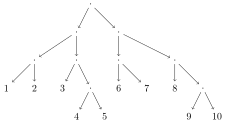

In [30]:
v = PlainVtree(10, :balanced)
g, label = DiGraph(v)
TikzGraphs.plot(g, label)

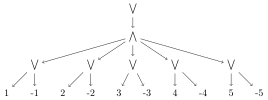

In [31]:
lc = fully_factorized_circuit(PlainLogicCircuit, 5)
g, label = DiGraph(lc)
TikzGraphs.plot(g, label)

## Probabilistic Circuits

In [32]:
using ProbabilisticCircuits

┌ Info: Precompiling ProbabilisticCircuits [2396afbe-23d7-11ea-1e05-f1aa98e17a44]
└ @ Base loading.jl:1278


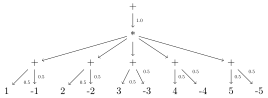

In [33]:
pc = fully_factorized_circuit(ProbCircuit, 5)
uniform_parameters(pc)
g, label, edge_labels = DiGraph(pc)
TikzGraphs.plot(g, label; edge_labels=edge_labels, edge_style="font=\\tiny")

helper function

In [34]:
# You can skip this part. Includes helper functions to make partial observations from arrays of strings
# so its easier to present.

# Make one observation from list of string describing the observation
#
# For example, ["smoker", "male"] sets 
#   1) The mentioned features to the correct values.
#   2) Every feature not mentioned to missing values. 
FEATURES = 36;
function make_one_observation(obs)
    result = missings(Bool, FEATURES)
    for k in obs
        # Smoking
        if lowercase(k) == "smoker"
            result[7:8] .= [0, 1]
        elseif lowercase(k) == "!smoker"
            result[7:8] .= [1, 0]
        # Gender
        elseif lowercase(k) == "male"
            result[13:14] .= [1, 0]
        elseif lowercase(k) == "female"
            result[13:14] .= [0, 1]
        # Region
        elseif lowercase(k) == "southeast"
            result[9:12] .= [0, 0, 1, 0]
        elseif lowercase(k) == "southwest"
            result[9:12] .= [0, 1, 0, 0]
        # Child
        elseif lowercase(k) == "1-child"
            result[1:6] .= [0,1,0,0,0,0]
        end
    end
    result
end;

function make_observations(obs)
    count = size(obs)[1]
    result = missings(Bool, count, FEATURES)
    for i=1:count
        result[i, :] .= make_one_observation(obs[i])
    end
    DataFrame(result)
end;

load data

In [35]:
using CSV
train_x = DataFrame(BitArray(Matrix(CSV.read("insurance/insurance_train_x.csv"))))
println("\"Insurance\" training set has $(num_features(train_x)) variables and $(num_examples(train_x)) samples.")
train_y = CSV.read("insurance/insurance_train_y.csv");

"Insurance" training set has 36 variables and 935 samples.


Here for the purpose of this demo, we load a pretrained probabilistic circuit:

In [41]:
pc = load_prob_circuit(zoo_psdd_file("insurance.psdd"))
println("Probablistic Circuit with $(num_nodes(pc)) nodes.")

Probablistic Circuit with 27493 nodes.


### Queries
#### EVI: Complete Evidence Query

All features are observed, we want to compute the probability: $$ P(x) $$

In [42]:
log_likelihood_avg(pc, train_x)

-9.711713749299689

#### MAR: Marginal Query (partial evidence)

Now, what happens if we only observe a subset of the features $X^o$? We want to compute:

$$ P(X^o) = \sum_{x^m} P(X^o X^m) $$

**Problem:** Computing above query is usually not tractable as it involves summing over exponential (infinite) possible worlds.

**Good News:** In probabilistic circuits, if the circuit is **smooth** and **decomposable**, we can do this tractably. No need to enumerate all possible worlds.

In [44]:
marg_data = make_observations([["smoker"], 
                       ["female"], 
                       ["female", "smoker"], 
                       ["southeast", "male", "1-child", "smoker"]],
                    )
prob = exp.(marginal(pc, marg_data))
println("Probability of being smoker? ", prob[1])
println("Probability of being female smoker? ", prob[3])
println("Probability of being male smoker with one child living in the southeast? ", prob[4])

Probability of being smoker? 0.18403563
Probability of being female smoker? 0.096237846
Probability of being male smoker with one child living in the southeast? 0.0009639263


#### CON: Conditional Queries

Given some observations $X^o$, we want to compute probabilities conditioned on the observations:

$$ P(Q \mid X^o) $$

if we can do marginals tractably, we can also do conditionals tractably:

$$ P(Q \mid X^o) = \cfrac{P(Q, X^o)}{P(X^o)} $$

In [45]:
println(" P('smoker' | 'female') = $(prob[3]/prob[2])")

 P('smoker' | 'female') = 0.20398751


#### MPE: Most Probable Explanation
aka Maximum A Posteriori (MAP)

Given some observations $X^o$, we want to compute the event which is most likely to heppen

$$ argmax_{q}P(q \mid X^o) $$

In probabilistic circuits, if the circuit is **deterministic** and **decomposable**, we can do this tractably.

In [ ]:
# TODO

#### Advanced queries: expected predictions
What about reasoning about predictive models such as regression models:


We are interested in computing **expected predictions**

- Appears all the time in machine learning, such as handling missing data
- We can do this tractably!


$$ \Large \mathbb{E}_{\mathbf{x}^m\ \sim\ p(\mathbf{x}^m\ \mid\ \mathbf{x}^o )}\left[\ f( \mathbf{x}^o \mathbf{x}^m) \ \right] $$

- In above equation $ \mathbf{x}^m $ = missing features, and $ \mathbf{x}^o $ = observed features.

- We have two separate models $p$ and $f$.

- Expected Prediction useful for:
  - Handling missing values at test time
  - Reasoning about behaviour of predictive models

In [51]:
rc = load_logistic_circuit(zoo_lc_file("insurance.circuit"), 1)
println("Regression Circuit with $(num_nodes(rc)) nodes.")

Regression Circuit with 1076 nodes.


##### Sample Queries
1. How different are the insurance costs between smokers and non smokers?

In [60]:
data = make_observations([["!smoker"], 
                 ["smoker"]])
exps, exp_cache = Expectation(pc, rc, data)
println("Smoker    : \$ $(exps[2])");
println("Non-Smoker: \$ $(exps[1])");
println("Difference: \$ $(exps[2] - exps[1])");

Smoker    : $ 31355.33282984327
Non-Smoker: $ 8741.748027632839
Difference: $ 22613.584802210433


2. Is the predictive model biased by gender?

In [61]:
data = make_observations([["male"],
                 ["female"]])
exps, exp_cache = Expectation(pc, rc, data);
println("Female  : \$ $(exps[2])");
println("Male    : \$ $(exps[1])");
println("Diff    : \$ $(exps[2] - exps[1])");

Female  : $ 14170.126564819753
Male    : $ 13196.551315011335
Diff    : $ 973.5752498084184


3. Expecation and standard devation of few subpopulations

In [65]:
data = make_observations( [["southeast", "male", "1-child", "smoker"], 
                 ["southwest", "male", "1-child", "smoker"]])
exps, exp_cache = Expectation(pc, rc, data);
# Computes the second moment
mom2, mom_cache = Moment(pc, rc, data, 2);
# Computing Standard Deviation
stds = sqrt.( mom2 - exps.^2 );
# Living in South East, Smoker, Male, One child
println("mu: $(round(exps[1])), std = $(round(stds[1]))")

mu: 30975.0, std = 11229.0
